#### Import packages, set directories and parameters

In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
import math
from tqdm import tqdm
from Comparative_Analysis import Utilities as util
from joblib import Parallel, delayed
from Comparative_Analysis import Blast_Functions as blastfn
import time
import os
import copy
from scipy.stats import chi2, binom
from Comparative_Analysis import Alignment as alignfn
from Bio.Align.Applications import MuscleCommandline
import subprocess
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
project_dir = 'F:/Project_Data/MITE_Project'
mycobacteria_seq_dir = 'F:/Datasets/NCBI_Refseq_Mycobacteriaceae_Complete_Annot_20230511/data'
actinobacteria_seq_dir = 'F:/Datasets/NCBI_Refseq_Actinomycetes_Complete_Annot_20230511/data'
tb_species = 'AL123456.3' 
tb_annotation_dirname = 'GCA_000195955.2'
min_region_length = 7 
full_build = False
num_cores = 16
core_numbers = list(range(1, num_cores+1))
muscle_exe = 'C:/Users/nicho/Muscle/muscle3.8.31_i86win32.exe'
full_run = True

In [4]:
mycobacteria_dirs = []
for dir in util.list_dirs(mycobacteria_seq_dir):
    if os.path.exists(mycobacteria_seq_dir + '/' + dir + '/genomic.gbff'):
        mycobacteria_dirs.append(dir)

In [5]:
actinobacteria_dirs = []
for dir in util.list_dirs(actinobacteria_seq_dir):
    if os.path.exists(actinobacteria_seq_dir + '/' + dir + '/genomic.gbff'):
        actinobacteria_dirs.append(dir)

In [6]:
tb_mycobacteria_rbh = pd.read_csv(project_dir + '/tb_mycobacteria_reciprocal_best_hits.csv')

In [7]:
names_dict = {}
dirname_dict = {}
for dirname in (mycobacteria_dirs):
        for genome_record in SeqIO.parse(mycobacteria_seq_dir + '/' + dirname + '/genomic.gbff', "genbank"):
            accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
            names_dict[accession_ver] = genome_record.annotations['organism']
        dirname_dict[dirname] = genome_record.annotations['organism']

In [8]:
def reverse_complement(seq_string):
    temp = []
    for char in reversed(seq_string):
        if char == 'A':
            comp = 'T'
        elif char == 'T':
            comp = 'A'
        elif char == 'C':
            comp = 'G'
        elif char == 'G':
            comp = 'C'
        else:
            comp = char
        temp.append(comp)
    return ''.join(temp)

#### Lookup function to find orthologs in M.tb based on reciprocal best hit outputs from BLAST against mycobacterial reference sequences

In [9]:
def ortholog_in_mtb(accession_ver, locus):
    gene = accession_ver + '@' + locus
    temp = tb_mycobacteria_rbh.query('target_ref == @gene and query_species == @tb_species')
    if len(temp) == 1:
        for i, r in temp.iterrows():
            temp2 = r['query_ref']
            return temp2.split('@')[1]
    else:
        return 'No_orth'

#### Produce reference FASTA files (a) TB and (b, c) all mycobacteria, actionobacteria for searching against motifs

In [9]:
genome_record = next(SeqIO.parse(mycobacteria_seq_dir + '/' + tb_annotation_dirname + '/genomic.gbff', "genbank"))
tot = 0
for feature in genome_record.features:
    a = feature.qualifiers
    if feature.type not in ['source','gene'] and (int(feature.location.start) < int(feature.location.end)) and (int(feature.location.end) - int(feature.location.start)) < 1000000:
        if feature.type == 'CDS':
            tot+=1
print(tot)

4031


In [31]:
genome_record = next(SeqIO.parse(mycobacteria_seq_dir + '/' + tb_annotation_dirname + '/genomic.gbff', "genbank"))
mtb_sequence = str(genome_record.seq)
accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
util.produce_fasta_file([[accession_ver, mtb_sequence]], project_dir + '/mtb_seq')

In [12]:
if full_run == True:
    temp = []
    for dir in util.list_dirs(mycobacteria_seq_dir): 
        if os.path.exists(mycobacteria_seq_dir + '/' + dir + '/genomic.gbff'):
            for genome_record in (SeqIO.parse(mycobacteria_seq_dir + '/' + dir + '/genomic.gbff', "genbank")):
                accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
                full_sequence = str(genome_record.seq)
                temp.append([accession_ver, full_sequence])
    util.produce_fasta_file(temp, project_dir + '/all_seq')

100%|██████████| 135/135 [00:11<00:00, 11.83it/s]


In [38]:
if full_run == True:
    temp = []
    for dir in util.list_dirs(actinobacteria_seq_dir): 
        if os.path.exists(actinobacteria_seq_dir + '/' + dir + '/genomic.gbff'):
            for genome_record in (SeqIO.parse(actinobacteria_seq_dir + '/' + dir + '/genomic.gbff', "genbank")):
                accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
                full_sequence = str(genome_record.seq)
                temp.append([accession_ver, full_sequence])
    util.produce_fasta_file(temp, project_dir + '/all_actinobacteria_seq')

100%|██████████| 900/900 [01:05<00:00, 13.66it/s]


#### Functions to look up annotated region(s) to which gene co-ordinates correspond to in specified organism

In [10]:
def annotated_regions_dataset(num_subsets, subset_num, dir_list, seqdir, cds_only = False): 
    output = []
    sequence_dirs = util.chunk_list(dir_list, num_subsets, subset_num)
    for dirname in sequence_dirs:
        annotated_regions = []
        intergenic_regions = []
        for record in (SeqIO.parse(seqdir + '/'+dirname+'/genomic.gbff', "genbank")):
            accession_ver = record.annotations['accessions'][0] + '.' + str(record.annotations['sequence_version'])
            for feature in record.features:
                a = feature.qualifiers
                if feature.type not in ['source','gene'] and (int(feature.location.start) < int(feature.location.end)) and (int(feature.location.end) - int(feature.location.start)) < 1000000:
                    if cds_only == True and not(feature.type == 'CDS'):
                        continue
                    else:
                        if not(a.get("product") == None):
                               product = a.get("product")[0]
                        else:
                               product = ''
                        if not(a.get("locus_tag")==None):
                            locus_tag = a.get("locus_tag")[0]
                        else:
                            locus_tag = feature.type
                        annotated_regions.append((locus_tag, product, feature.type, int(feature.location.start), int(feature.location.end), str(feature.location.strand)))
            annotated_regions.sort(key = lambda x: x[4])
            prev_strand = 0
            prev_locus = ''
            prev_product = ''
            max_stop = 0
            for n, (locus, product, feature_type, start, stop, strand) in enumerate(annotated_regions):
                if start > max_stop:
                    intergenic_regions.append([prev_locus+':'+locus, prev_product + ':' + product, 'Inter-feature',max_stop, start, str(prev_strand)+':'+str(strand)])
                if stop > max_stop:
                    prev_locus = locus
                    prev_product = product
                    prev_strand = strand
                max_stop = max(max_stop, stop)    
            for x in intergenic_regions:
                annotated_regions.append(x)
            annotated_regions.sort(key = lambda x : x[4])
            output.append([accession_ver, annotated_regions])
    return output

In [11]:
parallel_output = Parallel(n_jobs=-1)(delayed(annotated_regions_dataset)(num_cores, core_number, mycobacteria_dirs, mycobacteria_seq_dir) for core_number in core_numbers)
annotated_regions_dict = {}
for x in parallel_output:
    for y in x:
        annotated_regions_dict[y[0]] = y[1]
parallel_output = Parallel(n_jobs=-1)(delayed(annotated_regions_dataset)(num_cores, core_number, mycobacteria_dirs, mycobacteria_seq_dir, True) for core_number in core_numbers)
cds_annotated_regions_dict = {}
for x in parallel_output:
    for y in x:
        cds_annotated_regions_dict[y[0]] = y[1]

In [13]:
def location(accession_ver, start1, end1, annotation_lookup_dictionary):
    feature_matches = []
    for (locus, product, feature, start, stop, strand) in annotation_lookup_dictionary[accession_ver]:
            if start< end1 and stop > start1:
                overlap = str(int(100*(min(end1, stop) - max(start1, start))/ (end1-start1)))+'%'
                feature_matches.append([locus, product, feature, overlap, strand])
    return feature_matches

#### Create dictionary of upstream sequences in mycobacteria dataset - sequence continue upstream to the next CDS not next feature (e.g. regions annotated as repeat regions would be included

In [14]:
def generate_upstream_sequence_dataset(num_subsets, subset_num, dir_list, seqdir, additional_offset = 0):     # Set additional offset = 3 if you want start codon of downstream CDS to be included - useful for alignment 
    sequence_dirs = util.chunk_list(dir_list, num_subsets, subset_num)
    upstream_cds_regions = []
    for dirname in (sequence_dirs):
        all_features = []
        cds_features = []
        for genome_record in SeqIO.parse(mycobacteria_seq_dir + '/' + dirname + '/genomic.gbff', "genbank"):
            accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
            full_sequence = str(genome_record.seq)
            len_full_sequence = len(full_sequence)
            for feature in genome_record.features:
                if feature.type in ['gene', 'source']:
                    continue
                a = feature.qualifiers
                feature_type = feature.type
                if a.get("locus_tag") != None:
                    locus_tag = a.get("locus_tag")[0]
                    accession_locus = accession_ver + '@' + locus_tag
                else:
                    accession_locus  = ''
                (start, stop, strand) = (int(feature.location.start), int(feature.location.end), int(feature.location.strand))
                all_features.append([accession_locus, feature_type, start, stop, strand])
                if feature_type == 'CDS':
                    cds_features.append([accession_locus, feature_type, start, stop, strand])
            
            features = cds_features  # Replace with line below if you want to go upstream only to next annotated feature and not next CDS
            #features = all_features
            
            # Positive strand upstream 
            features.sort(key = lambda x: x[2])
            max_stop = 0
            for (accession_locus, feature_type, start, stop, strand) in features:
                if max_stop < start and feature_type == 'CDS' and strand == 1 and start - max_stop < 100000:    #Avoid joins where biopython interprets inconsistently 
                    upstream_cds_regions.append([accession_locus, max_stop, start, strand, full_sequence[max_stop: start+additional_offset]])
                max_stop = max(max_stop, stop)
            # Negative strand upstream
            features.sort(key = lambda x: x[3], reverse = True)
            min_start = len(full_sequence)-1
            for (accession_locus, feature_type, start, stop, strand) in features:
                if stop < min_start and feature_type == 'CDS' and strand == -1 and min_start - stop < 100000:
                    upstream_cds_regions.append([accession_locus, stop, min_start, strand, reverse_complement(full_sequence[stop-additional_offset: min_start])])
                min_start = min(min_start, start)
    return (upstream_cds_regions)           

In [15]:
if full_run == True:
#if 1==0:
    mycobacteria_upstream_dict = {}
    parallel_output = Parallel(n_jobs=-1)(delayed(generate_upstream_sequence_dataset)(num_cores, core_number, mycobacteria_dirs, mycobacteria_seq_dir) for core_number in core_numbers)
    for x in parallel_output:
        for n in x:
            mycobacteria_upstream_dict[n[0]] = [n[1], n[2], n[3], n[4]]
    with open(project_dir + '/mycobacteria_upstream_dict.pkl', 'wb') as f:
        pickle.dump(mycobacteria_upstream_dict, f) 
else:
    with open(project_dir + '/mycobacteria_upstream_dict.pkl', 'rb') as f:
        mycobacteria_upstream_dict = pickle.load(f)    

#### Functions to run MEME and FIMO

In [16]:
def run_meme(search_regions_loc, output_dir, min_width, min_sites):
    subprocess.run('wsl export PATH=$HOME/meme/bin:$HOME/meme/libexec/meme:usr/bin:$PATH ; meme '+ util.wslname(search_regions_loc) + ' -oc '+ util.wslname(output_dir) +' -dna -evt 0.001 -p 8 -revcomp -mod anr -brief 4000 -minw ' + str(min_width) +' -maxw 200 -minsites ' + str(min_sites)
               , shell=True)

In [17]:
def run_fimo(motif_file, sequence_to_search_file, output_dir):
    subprocess.run('wsl export PATH=$HOME/meme/bin:$HOME/meme/libexec/meme:usr/bin:$PATH ; fimo -oc ' + util.wslname(output_dir) + ' ' + util.wslname(motif_file) + ' ' + util.wslname(sequence_to_search_file)
               , shell=True)

In [18]:
def produce_matched_sequence_file(hit_df, output_file, q_value):
    matched_sequences = []
    for i, r in hit_df.iterrows():
        if '#' in r['motif_id']:
            continue
        if float(r['q-value']) < q_value:
            matched_sequences.append([str(r['start'])+'_'+str(r['stop']), r['matched_sequence']])
    util.produce_fasta_file(matched_sequences, output_file)

#### Import list of significantly up/downregulated genes based on experimental data supplied and produce fasta file of upstream sequences (from upstream region dictionary created above)

In [21]:
regulation_type_dict = {}
p_val_dict = {}
downreg_genes = pd.read_excel(project_dir + '/2022-10-02_data_NU_NAs_renamed.xlsx', sheet_name = 'significant genes downregulated')
upreg_genes = pd.read_excel(project_dir + '/2022-10-02_data.xlsx', sheet_name = 'significant genes upregulated')
all_genes = pd.read_excel(project_dir + '/2022-10-02_data.xlsx', sheet_name = 'all genes')
gene_list = []
for i, r in downreg_genes.iterrows():
    gene_list.append(r['Locus'])
    regulation_type_dict[r['Locus']] = 'Downregulated'
for i, r in upreg_genes.iterrows():
    gene_list.append(r['Locus'])
    regulation_type_dict[r['Locus']] = 'Upregulated'
for i, r in all_genes.iterrows():
    if r['padj'] == 'NA':
        p_val_dict[r['Locus']] = 999
    else:    
        p_val_dict[r['Locus']] = r['padj']

In [25]:
significant_upstream_tb_regions = []
temp_dict = {}
for gene in gene_list:
    locus = tb_species + '@' + str(gene)
    if locus in mycobacteria_upstream_dict:
        upstream_region = mycobacteria_upstream_dict[locus][3]  
        (start, stop) = (mycobacteria_upstream_dict[locus][0],  mycobacteria_upstream_dict[locus][1])
        if (start, stop) in temp_dict:
            pass  # Eliminate upstream region if already there (e.g if neighbouring divergent pair)
        else:
            temp_dict[(start, stop)] = 1      
            if len(upstream_region) >= min_region_length:
                significant_upstream_tb_regions.append([locus, upstream_region])
util.produce_fasta_file(significant_upstream_tb_regions, project_dir + '/significant_upstream_tb_regions.faa')

100%|██████████| 175/175 [00:00<00:00, 175137.96it/s]


##### Run MEME against the upstream regions to find motifs, then search motifs against full TB sequence using FIMO and select hits with q-value < 1e-3 for fitting a final Motif (Second_MEME_Upstream_Output) - Slide 4

In [35]:
run_meme(project_dir + '/significant_upstream_tb_regions.faa', project_dir + '/MEME_Upstream_Output',3,5)
run_fimo(project_dir + '/MEME_Upstream_Output/meme.txt', project_dir + '/mtb_seq' , project_dir + '/FIMO_Upstream_Output')
fimo_upstream_hits = pd.read_csv(project_dir + '/FIMO_Upstream_Output/fimo.tsv', sep='\t')
produce_matched_sequence_file(fimo_upstream_hits, project_dir + '/fimo_upstream_hit_sequences.faa', q_value = 1e-3)
run_meme(project_dir + '/fimo_upstream_hit_sequences.faa', project_dir + '/Second_MEME_Upstream_Output',3,5)

100%|██████████| 110/110 [00:00<?, ?it/s]


##### Produce FIMO hits against this motif for TB and all mycobacteria and all actinobacteria

In [36]:
run_fimo(project_dir + '/Second_MEME_Upstream_Output/meme.txt', project_dir + '/mtb_seq' , project_dir + '/Second_FIMO_Upstream_Output')

In [37]:
run_fimo(project_dir + '/Second_MEME_Upstream_Output/meme.txt', project_dir + '/all_seq' , project_dir + '/All_Species_Second_FIMO_Upstream_Output')

In [39]:
run_fimo(project_dir + '/Second_MEME_Upstream_Output/meme.txt', project_dir + '/all_actinobacteria_seq' , project_dir + '/All_Actinobacteria_Species_Second_FIMO_Upstream_Output')

##### Use all significant mycobacterial species hits obtained above to fit motif which best fits for overall mycobacteria.   For each mycobacterial species one at a time, we then use this to search for occurrences of this motif (then refine into a motif which represents the best fit for that species and search again),  Hits in /Single_Species_MEME_FIMO Final motif in /Temp_Second_Meme_Upstream_Output.   The idea of this is that the motif might occur in a slightly modified form in different mycobacteria species.  So we want to output a species-specific version of the motif which best represents occurrences in each particular species  

In [20]:
fimo_upstream_hits = pd.read_csv(project_dir + '/All_Species_Second_FIMO_Upstream_Output/fimo.tsv', sep='\t')
produce_matched_sequence_file(fimo_upstream_hits, project_dir + '/all_species_hit_sequences.faa', q_value = 1e-3)
run_meme(project_dir + '/all_species_hit_sequences.faa', project_dir + '/All_Species_Output',3,5)

100%|██████████| 2757/2757 [00:00<00:00, 306047.43it/s]


In [ ]:
if full_run == True:
    for dirname in tqdm(mycobacteria_dirs):
        temp = []
        for genome_record in (SeqIO.parse(mycobacteria_seq_dir + '/' + dirname + '/genomic.gbff', "genbank")):
            ntsequence = str(genome_record.seq)
            accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
            temp.append([accession_ver, ntsequence])
        util.produce_fasta_file(temp, project_dir + '/temp_seq')
        
        run_fimo(project_dir + '/All_Species_Output/meme.txt', project_dir + '/temp_seq' , project_dir + '/Single_Species_MEME_FIMO/' + dirname)
        fimo_upstream_hits = pd.read_csv(project_dir + '/Single_Species_MEME_FIMO/' + dirname + '/fimo.tsv', sep='\t')
        produce_matched_sequence_file(fimo_upstream_hits, project_dir + '/Single_Species_MEME_FIMO/' + dirname + '/temp_fimo_upstream_hit_sequences.faa', q_value = 1e-3)
        run_meme(project_dir + '/Single_Species_MEME_FIMO/' + dirname + '/temp_fimo_upstream_hit_sequences.faa', project_dir + '/Single_Species_MEME_FIMO/' + dirname + '/Temp_Second_MEME_Upstream_Output',3,5)

        run_fimo(project_dir + '/Single_Species_MEME_FIMO/' + dirname + '/Temp_Second_MEME_Upstream_Output/meme.txt', project_dir + '/temp_seq' , project_dir + '/Single_Species_MEME_FIMO/' + dirname)
        fimo_upstream_hits = pd.read_csv(project_dir + '/Single_Species_MEME_FIMO/' + dirname + '/fimo.tsv', sep='\t')
        produce_matched_sequence_file(fimo_upstream_hits, project_dir + '/Single_Species_MEME_FIMO/' + dirname + '/temp_fimo_upstream_hit_sequences.faa', q_value = 1e-3)
        run_meme(project_dir + '/Single_Species_MEME_FIMO/' + dirname + '/temp_fimo_upstream_hit_sequences.faa', project_dir + '/Single_Species_MEME_FIMO/' + dirname + '/Temp_Second_MEME_Upstream_Output',3,5)

##### Produce dictionary of motif hits for each species based on ortholog of hits in M.tb.  Count to find the number of different species having a motif hit in the orthologous region.  Output to file and graph (Slide 9)

In [24]:
appearance_dict = {}
for dirname in tqdm(mycobacteria_dirs):
    temp_set = set()
    temp_set_2 = set()
    temp_list_3 = []
    temp_fimo_hits = pd.read_csv(project_dir + '/Single_Species_MEME_FIMO/' + dirname + '/fimo.tsv', sep='\t')
    for i, r in temp_fimo_hits.iterrows():
        if '#' in r['motif_id']:
            continue
        organism = r['sequence_name']
        motif_id = r['motif_alt_id']
        if float(r['q-value']) < 1e-5:
            temp = location(r['sequence_name'],int(r['start']), int(r['stop']), cds_annotated_regions_dict)
            ortholog_orientations = []
            for x in temp:
                if len(x[0].split(':')) == 1:
                    ortholog_orientations.append((ortholog_in_mtb(organism, x[0]), 'I'))
                else:
                    a = x[0].split(':')
                    b = x[4].split(':')
                    if b[0] == '1':
                        ortholog_orientations.append((ortholog_in_mtb(organism, a[0]), 'U'))
                    else:
                        ortholog_orientations.append((ortholog_in_mtb(organism, a[0]), 'D'))
                    if b[1] == '1':
                        ortholog_orientations.append((ortholog_in_mtb(organism, a[1]), 'D'))
                    else:
                        ortholog_orientations.append((ortholog_in_mtb(organism, a[1]), 'U'))
            for x in ortholog_orientations:
                temp_list_3.append(x)                                          
            temp2 = ([x[0].split(':') for x in temp])
            for x in temp2:
                temp_set = temp_set.union({ortholog_in_mtb(organism, w) for w in set(x)})
                temp_set_2 = temp_set_2.union(set(x))
    #print(temp_set)
    temp_set_3 = set(temp_list_3)
    
    for ortholog in temp_set_3:
        if ortholog in appearance_dict:
            appearance_dict[ortholog].append(dirname_dict[dirname])
        else:
            appearance_dict[ortholog] = [dirname_dict[dirname]]

100%|██████████| 100/100 [06:08<00:00,  3.68s/it]


<AxesSubplot:xlabel='Orthologue_region', ylabel='Species_hits'>

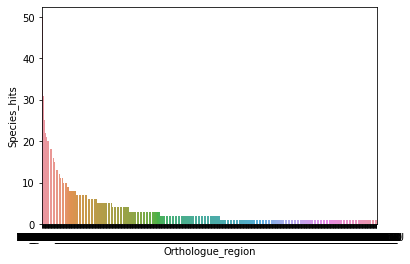

In [26]:
out_file = []
temp = []
for k, v in appearance_dict.items():
    temp.append((k[0], k[1], len(v), v))
temp.sort(key = lambda x: x[2], reverse = True)
for (x, y, l, m) in temp:
    if 1==1:
        out_file.append([str(x)+'_'+str(y), l])
    #print(x, y, l, m)
out_df = pd.DataFrame(out_file, columns = ['Orthologue_region', 'Species_hits'])
out_df.to_csv(project_dir + '/out_df.csv')
sns.barplot(data = out_df, x = 'Orthologue_region', y = 'Species_hits')


##### Output motifs per species for display in R (slide 8) - note motif_1 is selected as this corresponds to the MITE motif

In [27]:
temp = []
from Bio import motifs
for dirname in mycobacteria_dirs:
    filename = project_dir + '/Single_Species_MEME_FIMO/'+dirname +'/Temp_Second_MEME_Upstream_Output/meme.xml'
    if os.path.exists(filename):
        with open(filename) as f:
            record = motifs.parse(f, 'MEME')
        for motif in record:
            if motif.id == 'motif_1':
                temp.append([dirname_dict[dirname].replace(' ','_').replace('[','').replace(']',''), str(motif.consensus)])
util.produce_fasta_file(temp, project_dir + '/unaligned_motifs.faa')
cline = MuscleCommandline(muscle_exe, input= project_dir + '/unaligned_motifs.faa', out = project_dir + '/aligned_motifs.faa')
stdout, stderr = cline()

100%|██████████| 66/66 [00:00<?, ?it/s]


In [48]:
temp = util.read_fasta_to_array(project_dir + '/aligned_motifs.faa')

In [49]:
for dirname in mycobacteria_dirs:
    species = dirname_dict[dirname].replace(' ','_').replace('[','').replace(']','')
    if species in temp[0]:
        pass
    else:
        temp[0].append(species)
        temp[1].append('-'*len(temp[1][0]))
temp_2 = []
for (x, y) in zip(temp[0],temp[1]):
    temp_2.append([x,y])
util.produce_fasta_file(temp_2, project_dir + '/aligned_motifs_plus_blanks.faa')

100%|██████████| 100/100 [00:00<?, ?it/s]


#####  Produce dictionary of all motif hits in each mycobacterial species

In [28]:
hit_dict = {}
for dirname in tqdm(mycobacteria_dirs):
    temp_fimo_hits = pd.read_csv(project_dir + '/Single_Species_MEME_FIMO/' + dirname + '/fimo.tsv', sep='\t')

    for i, r in temp_fimo_hits.iterrows():
        if '#' in r['motif_id']:
            continue
        organism = r['sequence_name']
        motif_id = r['motif_alt_id']
        temp = location(r['sequence_name'],int(r['start']), int(r['stop']), annotated_regions_dict)
        if len(temp) > 0:
            temp.sort(key = lambda x: float(x[3].strip('%')), reverse = True)
            main_location = temp[0] #temp[0]
        else:
            main_location = ''
        info = [int(r['start']), int(r['stop']), r['strand'], float(r['q-value']), main_location, r['matched_sequence'], r['motif_alt_id']]
        if organism in hit_dict:
            hit_dict[organism].append(info)
        else:
            hit_dict[organism] = [info]

for k, v in hit_dict.items():
    v.sort(key = lambda x: x[0])

100%|██████████| 100/100 [07:29<00:00,  4.50s/it]


##### Classify hits for M. tb based on whether they are "paired" (near a complement of the motif forming a motif + region of up to 20 nt then the complement of the motif) or unpaired.  Data output (Motif hits in M.tb tab)  Output alignments of the two categories (Slides 6 and 7) 

In [32]:
paired_motif_sequences = []
unpaired_motif_sequences = []
temp_df_list =[]
gene_pairs = []
sole_genes = []
inter_distances = []
occurrences = 0
pairs = 0
no_pairs = 0
v = hit_dict[tb_species]
last_stop = -999
pair_poss = 0
for n, (start, stop, strand, q, loc, matched_seq, motif_id) in enumerate(v):
    if q > 1e-2 or not(motif_id == 'MEME-1'):
        continue
    else:
        occurrences +=1
        if start - last_stop < 100 and pair_poss == 1:
            inter_distances.append(start-last_stop)
            last_temp = copy.deepcopy(v[last_n])
            last_temp.append("paired")
            latest_temp = copy.deepcopy(v[n])
            latest_temp.append("paired")
            temp_df_list.append(last_temp)
            temp_df_list.append(latest_temp)
            if start - last_stop < 20:
                genes = v[n][4][0].split(":")
                genes2 = v[last_n][4][0].split(":")
                pref = 'H37Rv_'
                for gene in genes:
                    if gene in set(gene_list):
                        pref = v[n][4][0] + '___H37Rv_'
                for gene in genes2:
                    if gene in set(gene_list):
                        pref = v[last_n][4][0] + '___H37Rv_'
                paired_motif_sequences.append([pref+str(v[last_n][0])+'_'+str(v[n][1]), mtb_sequence[v[last_n][0]:v[n][1]]])
            pair_poss = 0
            pairs+=1
            for x in v[n][4][0].split(':'):
                gene_pairs.append(x)
            for x in v[last_n][4][0].split(':'):
                gene_pairs.append(x)

        elif pair_poss == 1:
            last_temp = copy.deepcopy(v[last_n])
            last_temp.append("Unpaired")
            temp_df_list.append(last_temp)
            #print("no_pair", v[last_n])
            no_pairs+=1#
            for x in v[last_n][4][0].split(':'):
                sole_genes.append(x)
            genes2 = v[last_n][4][0].split(":")
            pref = 'NP_H37Rv_'
            for gene in genes2:
                if gene in set(gene_list):
                    pref = v[last_n][4][0] + '___NP_H37Rv_'
            if v[last_n][2] == '+':
                unpaired_motif_sequences.append([pref+str(v[last_n][0]-30)+'_'+str(v[last_n][1]+40), mtb_sequence[v[last_n][0]-30:v[last_n][1]+40]])
            else:
                unpaired_motif_sequences.append([pref+str(v[last_n][0]-30)+'_'+str(v[last_n][1]+40), util.reverse_complement(mtb_sequence[v[last_n][0]-30:v[last_n][1]+40])])
        else:
            pair_poss=1
        last_stop = stop
        last_n = n
print(pairs, no_pairs)
print(len(inter_distances))
print(inter_distances)
print(occurrences)

69 23
69
[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 98, 17, 17, 17, 17, 19, 17, 17, 17, 17, 17, 17, 16, 17, 17, 17, 17, 17, 18, 17, 17, 17, 17, 17, 17, 18, 17, 17, 17, 14, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]
162


In [33]:
util.produce_fasta_file(paired_motif_sequences, project_dir + '/unaligned_pair_motifs.faa')
cline = MuscleCommandline(muscle_exe, input= project_dir + '/unaligned_pair_motifs.faa', out = project_dir + '/aligned_pair_motifs.faa')
stdout, stderr = cline()
util.produce_fasta_file(unpaired_motif_sequences, project_dir + '/unaligned_unpaired_motifs.faa')
cline = MuscleCommandline(muscle_exe, input= project_dir + '/unaligned_unpaired_motifs.faa', out = project_dir + '/aligned_unpaired_motifs.faa')
stdout, stderr = cline()

100%|██████████| 23/23 [00:00<?, ?it/s]


In [35]:
temp= pd.DataFrame(temp_df_list, columns = ['start','stop','strand','q_val','region_info','matched_seq','motif','pair'])

In [36]:
temp['study_association'] = ''
for i, r in temp.iterrows():
    temp.at[i, 'type'] = r['region_info'][2]
    temp.at[i, 'product'] = r['region_info'][1]
    temp.at[i,'pct_occupancy'] = r['region_info'][3]
    genes = r['region_info'][0].split(":")
    associated_genes = []
    for gene in genes:
        if gene in set(gene_list):
            associated_genes.append(gene)
    temp.at[i, 'study_association'] = associated_genes
temp.to_csv(project_dir + '/motif_hits.csv')

##### This bit asssesses significance of whether there was overrepresentation of the motif in regions associated with those identified as up/downregulated in the study, however I think it's probably more of a coincidence, I think we found a wider motif by accident by looking at those intergenic regions, but it is probably not associated  

In [37]:
genes = []
v = hit_dict[tb_species]
for (start, stop, strand, q, loc, matched_seq, motif_id) in v:
    if q > 1e-2 or not(motif_id == 'MEME-1') :
        continue
    for x in loc[0].split(':'):
        genes.append(x)

In [44]:
b = set(genes)
inters = b.intersection(set(gene_list))
print(len(b), len(inters), len(gene_list))
print(1- binom.cdf(len(inters), len(b),(len(gene_list))/4031))

163 20 236
0.0005947770818272025


##### Number of motif hits in different species and output so can be merged with R to display info against phylo tree (bar chart in Slide 8)

In [57]:
names_hit_dict = {}
for dirname in tqdm(mycobacteria_dirs):
    temp_fimo_hits = pd.read_csv(project_dir + '/Single_Species_MEME_FIMO/' + dirname + '/fimo.tsv', sep='\t')

    for i, r in temp_fimo_hits.iterrows():
        if '#' in r['motif_id']:
            continue
        organism = names_dict[r['sequence_name']]
        motif_id = r['motif_alt_id']
        temp = location(r['sequence_name'],int(r['start']), int(r['stop']), annotated_regions_dict)
        if len(temp) > 0:
            temp.sort(key = lambda x: float(x[3].strip('%')), reverse = True)
            main_location = temp[0] #temp[0]
        else:
            main_location = ''
        info = [int(r['start']), int(r['stop']), r['strand'], float(r['q-value']), main_location, r['matched_sequence'], r['motif_alt_id']]
        if organism in names_hit_dict:
            names_hit_dict[organism].append(info)
        else:
            names_hit_dict[organism] = [info]
for k, v in names_hit_dict.items():
    v.sort(key = lambda x: x[0])

100%|██████████| 100/100 [07:33<00:00,  4.53s/it]


In [68]:
hit_info = []
for k, v in names_hit_dict.items():
    ct = 0
    temp = []
    for (start, stop, strand, q, loc, matched_seq, motif_alt_id) in v:
        if q > 1e-2 or not(motif_alt_id == 'MEME-1') or loc =='':
            continue
        else:
            ct +=1
        for x in loc[0].split(':'):
            temp.append(x)
    #hit_info.append([k.replace(' ','_'),'Num_hits', len(set(temp))])
    hit_info.append([k.replace(' ','_'),'Num_hits', ct])
pd.DataFrame(hit_info, columns = ['name', 'variable', 'value']).to_csv(project_dir + '/Hit_Counts.csv')

##### Build phylogenetic tree (used for graphical displays only) for mycobacterial dataset by aligning in Muscle concatenated orthologues with more than 85% match present in all species, and then processing with MEGA

In [ ]:
max_len = len(tb_mycobacteria_rbh['target_species_name'].unique())

In [ ]:
full_ortholog_refs = []
temp = tb_mycobacteria_rbh.groupby('query_ref').agg({'target_ref': "count", 'percent_identical_matches': "min"}).reset_index()
temp = temp.query('target_ref == @max_len and percent_identical_matches > 85')
for i, r in temp.iterrows():
    full_ortholog_refs.append(r['query_ref'])

In [ ]:
def generate_protein_dataset(num_subsets, subset_num, dir_list, seqdir): 
    sequence_dirs = util.chunk_list(dir_list, num_subsets, subset_num)
    all_cds = []
    for dirname in (sequence_dirs):
        for genome_record in SeqIO.parse(seqdir + '/' + dirname + '/genomic.gbff', "genbank"):
            accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
            full_sequence = str(genome_record.seq)
            for feature in genome_record.features:
                a = feature.qualifiers
                if feature.type == 'CDS' and a.get("translation") != None and a.get("locus_tag") != None:
                    locus_tag = a.get("locus_tag")[0]
                    accession_locus = accession_ver + '@' + locus_tag
                    translation = a.get("translation")[0]
                    all_cds.append([accession_locus, translation])
    return (all_cds)           

In [ ]:
full_build = True
if full_build == True:
    parallel_output = Parallel(n_jobs=-1)(delayed(generate_protein_dataset)(num_cores, core_number, mycobacteria_dirs, mycobacteria_seq_dir) for core_number in core_numbers)
    protein_dict = {}
    for x in parallel_output:
        for temp in x[0]:
            protein_dict[temp[0]] = temp[1]

In [ ]:
concatenated_alignment_dict = {}
for ref in tqdm(full_ortholog_refs):
    temp_seq = []
    temp = tb_mycobacteria_rbh[tb_mycobacteria_rbh['query_ref'] == ref]
    for i, r in temp.iterrows():
        temp_seq.append([r['target_species_name'].replace(' ','_'),protein_dict[r['target_ref']]])
    util.produce_fasta_file(temp_seq, project_dir +'/temp_seq.fasta')    
    cline = MuscleCommandline(muscle_exe, input= project_dir +'/temp_seq.fasta', out=project_dir +'/temp_seq_alignment.fasta')
    result = cline();    
    alignment = util.read_fasta_to_array(project_dir +'/temp_seq_alignment.fasta')    
    for (name, sequence) in zip(alignment[0], alignment[1]):
        if name in concatenated_alignment_dict:
            temp2 = concatenated_alignment_dict[name]
            concatenated_alignment_dict[name] = temp2 + sequence
        else:
            concatenated_alignment_dict[name] = sequence
temp  = []
for k, v in concatenated_alignment_dict.items():
    temp.append([k, v])
util.produce_fasta_file(temp, project_dir + '/concatenated_alignment.fasta')

#####  Are there any hits in wider Actinobacteria?  No massively significant ones

In [14]:
actinobacteria_names_dict = {}
for dirname in tqdm(actinobacteria_dirs):
    for genome_record in (SeqIO.parse(actinobacteria_seq_dir + '/' + dirname + '/genomic.gbff', "genbank")):
        accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
        actinobacteria_names_dict[accession_ver] = genome_record.annotations['organism']


100%|██████████| 645/645 [05:23<00:00,  1.99it/s]


In [27]:
hit_dict = {}
temp_fimo_hits = pd.read_csv(project_dir + '/All_Actinobacteria_Species_Second_FIMO_Upstream_Output/fimo.tsv', sep='\t')
for i, r in temp_fimo_hits.iterrows():
    if '#' in r['motif_id']:
        continue
    organism = actinobacteria_names_dict[r['sequence_name']]
    motif_id = r['motif_alt_id']
    q_val = float(r['q-value'])
    if q_val < 1e-3 and motif_id == 'MEME-1' and not('Myco' in organism):
        print(organism, motif_id, q_val)
  


Corynebacterium singulare MEME-1 0.000512
Gordonia iterans MEME-1 0.000793
Gordonia amicalis MEME-1 0.000835
Salinispora tropica CNB-440 MEME-1 0.000835
Streptomyces tirandamycinicus MEME-1 0.000869
Corynebacterium epidermidicanis MEME-1 0.000873
Rathayibacter rathayi MEME-1 0.00094
Rhodococcus opacus PD630 MEME-1 0.000946
Streptomyces genisteinicus MEME-1 0.000993
